# Phishing Classification
This project meant for a binary classification of urls, (Phishing/Not Phishing).

## Import Libraries

In [1]:
from utils import plot_utils, analysis_utils
import pandas as pd
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

---
---
---

## Read Dataset
- Most of the features describe quantitative aspects, such as the number of occurrences (qty), length, or numerical encoding.
- The target column called `Phishing`

In [2]:
data = pd.read_csv('dataset_small.csv.xls')

In [3]:
data.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,2,0,0,0,0,0,0,0,0,0,...,1,4,2,3598,0,0,0,0,0,0
1,4,0,0,2,0,0,0,0,0,0,...,1,4,1,3977,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,1,2,1,10788,0,0,0,0,0,0
3,2,0,0,3,0,0,0,0,0,0,...,1,2,1,14339,1,0,0,0,0,1
4,1,1,0,4,0,0,0,0,0,0,...,1,2,1,389,1,1,0,0,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Columns: 112 entries, qty_dot_url to phishing
dtypes: float64(1), int64(111)
memory usage: 50.1 MB


---
---
---

## Data Cleansing

In [5]:
data.isna().sum().sum()

0

In [6]:
data.duplicated().sum()

1240

In [7]:
data.drop_duplicates(inplace=True)

---
---
---

## Check Cardinality

In [8]:
data.nunique()

qty_dot_url             23
qty_hyphen_url          30
qty_underline_url       22
qty_slash_url           25
qty_questionmark_url     6
                        ..
qty_redirects           15
url_google_index         3
domain_google_index      3
url_shortened            2
phishing                 2
Length: 112, dtype: int64

---

### Very high cardinality featuers

In [9]:
# Chcek features with higher than 100 unique values
very_high_cardinality_data = analysis_utils.check_cardinality(data, data.nunique() > 100)

length_url                  453
directory_length            239
file_length                 168
params_length               354
time_response             52592
asn_ip                     2567
time_domain_activation     7776
time_domain_expiration     2320
ttl_hostname               9365
dtype: int64


In [10]:
very_high_cardinality_data.head()

,length_url,directory_length,file_length,params_length,time_response,asn_ip,time_domain_activation,time_domain_expiration,ttl_hostname
0,14,-1,-1,-1,0.334573,8560,4927,185,3598
1,38,6,0,-1,1.326223,263283,8217,-1,3977
2,24,1,0,-1,3.969207,26496,258,106,10788
3,38,13,0,-1,0.495212,20013,2602,319,14339
4,46,27,0,-1,0.177876,41828,-1,-1,389


In [11]:
# Drop `time_response`, `asn_ip`, `time_domain_activation`, `time_domain_expiration` and `ttl_hostname` which has very high cardinality
columns_to_drop = ['time_response', 'asn_ip', 'time_domain_activation', 'time_domain_expiration', 'ttl_hostname']
data.drop(columns=columns_to_drop, axis=0, inplace=True)
very_high_cardinality_data.drop(columns=columns_to_drop, axis=0, inplace=True)

In [12]:
# check values of each features
analysis_utils.print_unique_values(very_high_cardinality_data)

length_url               , [14, 38, 24, 46, 45, 32, 29, 18, 11, 34, 21, 19, 31, 16, 12, 107, 22, 17, 228, 204]
directory_length         , [-1, 6, 1, 13, 27, 28, 18, 19, 5, 11, 16, 85, 35, 53, 48, 47, 24, 20, 34, 14]
file_length              , [-1, 0, 4, 9, 10, 78, 7, 23, 5, 14, 8, 13, 16, 15, 25, 6, 32, 3, 12, 11]
params_length            , [-1, 2, 164, 131, 73, 18, 5, 32, 92, 30, 42, 46, 157, 16, 23, 9, 3, 24, 165, 82]


In [13]:
# some features shouldn't have negative values so we can drop rows with negative values but lets see how many negative values we have:
columns_to_drop = analysis_utils.check_negative_count(very_high_cardinality_data)

Negative count in length_url               : 0
Negative count in directory_length         : 16519
Negative count in file_length              : 16519
Negative count in params_length            : 50042

 Columns that contains large number of negative values ['directory_length', 'file_length', 'params_length']


In [14]:
# Now, we can drop these features with that large number fo negative values (misformed values):
data.drop(columns=columns_to_drop, inplace=True)

---

### high cardinality features

In [15]:
# Chcek features with higher than 5 and less than or equal 100 unique values
high_cardinality_data = analysis_utils.check_cardinality(data, (data.nunique() > 5) & (data.nunique() <= 100))

qty_dot_url             23
qty_hyphen_url          30
qty_underline_url       22
qty_slash_url           25
qty_questionmark_url     6
                        ..
qty_params              19
qty_ip_resolved         15
qty_nameservers         16
qty_mx_servers          15
qty_redirects           15
Length: 62, dtype: int64


In [16]:
high_cardinality_data.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_and_params,qty_exclamation_params,qty_comma_params,qty_plus_params,qty_percent_params,qty_params,qty_ip_resolved,qty_nameservers,qty_mx_servers,qty_redirects
0,2,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,1,4,2,0
1,4,0,0,2,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,1,4,1,0
2,1,0,0,1,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,1,2,1,0
3,2,0,0,3,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,1,2,1,0
4,1,1,0,4,0,0,0,0,0,0,...,-1,-1,-1,-1,-1,-1,1,2,1,1


In [17]:
# check values of each features
analysis_utils.print_unique_values(high_cardinality_data)

qty_dot_url              , [2, 4, 1, 3, 7, 6, 5, 12, 14, 10, 8, 13, 9, 15, 17, 11, 16, 22, 24, 18]
qty_hyphen_url           , [0, 1, 7, 3, 2, 12, 6, 4, 5, 8, 10, 11, 9, 13, 18, 15, 17, 14, 24, 27]
qty_underline_url        , [0, 2, 1, 3, 5, 8, 4, 9, 7, 11, 6, 10, 14, 17, 19, 12, 13, 21, 16, 15]
qty_slash_url            , [0, 2, 1, 3, 4, 16, 6, 5, 12, 8, 7, 11, 10, 9, 20, 13, 19, 15, 21, 17]
qty_questionmark_url     , [0, 2, 1, 3, 9, 7]
qty_equal_url            , [0, 1, 2, 3, 6, 7, 11, 4, 10, 8, 9, 5, 12, 13, 14, 17, 15, 23, 20, 16]
qty_at_url               , [0, 1, 4, 2, 43, 3, 7, 5, 6, 14, 8, 11, 12, 10, 15]
qty_and_url              , [0, 2, 4, 1, 6, 5, 11, 3, 10, 13, 12, 7, 8, 9, 14, 26, 15, 16, 19, 17]
qty_exclamation_url      , [0, 1, 2, 10, 8, 4, 6, 5, 3, 9]
qty_space_url            , [0, 7, 2, 9, 1, 6, 3, 4]
qty_tilde_url            , [0, 1, 3, 4, 5, 2]
qty_comma_url            , [0, 3, 1, 2, 7, 5, 4, 11]
qty_plus_url             , [0, 1, 3, 2, 4, 5, 9, 19, 6, 7]
qty_asterisk_url 

In [18]:
# some features shouldn't have negative values so we can drop rows with negative values but lets see how many negative values we have:
columns_to_drop = analysis_utils.check_negative_count(high_cardinality_data)

Negative count in qty_dot_url              : 0
Negative count in qty_hyphen_url           : 0
Negative count in qty_underline_url        : 0
Negative count in qty_slash_url            : 0
Negative count in qty_questionmark_url     : 0
Negative count in qty_equal_url            : 0
Negative count in qty_at_url               : 0
Negative count in qty_and_url              : 0
Negative count in qty_exclamation_url      : 0
Negative count in qty_space_url            : 0
Negative count in qty_tilde_url            : 0
Negative count in qty_comma_url            : 0
Negative count in qty_plus_url             : 0
Negative count in qty_asterisk_url         : 0
Negative count in qty_hashtag_url          : 0
Negative count in qty_dollar_url           : 0
Negative count in qty_percent_url          : 0
Negative count in qty_tld_url              : 0
Negative count in qty_dot_domain           : 0
Negative count in qty_hyphen_domain        : 0
Negative count in qty_vowels_domain        : 0
Negative coun

In [19]:
# Now, we can drop these features with that large number fo negative values (misformed values):
data.drop(columns=columns_to_drop, inplace=True)

In [20]:
# And we can drop rows with negtive values form these columns:
data = data.loc[(data['qty_ip_resolved'] != -1) & (data['qty_redirects'] != -1)]

---

## Low Cardinality

In [21]:
# Chcek features with higher than 5 and less than or equal 100 unique values
low_cardinality_data = analysis_utils.check_cardinality(data, data.nunique() <= 5)

qty_comma_url                 1
qty_underline_domain          3
qty_slash_domain              1
qty_questionmark_domain       1
qty_equal_domain              1
qty_at_domain                 1
qty_and_domain                1
qty_exclamation_domain        1
qty_space_domain              1
qty_tilde_domain              1
qty_comma_domain              1
qty_plus_domain               1
qty_asterisk_domain           1
qty_hashtag_domain            1
qty_dollar_domain             1
qty_percent_domain            1
domain_in_ip                  2
server_client_domain          2
qty_questionmark_directory    2
qty_comma_directory           2
qty_hashtag_directory         2
qty_slash_file                2
qty_questionmark_file         2
qty_equal_file                5
qty_at_file                   4
qty_and_file                  5
qty_exclamation_file          5
qty_hashtag_file              2
qty_dollar_file               2
qty_space_params              4
qty_tilde_params              3
qty_aste

In [22]:
low_cardinality_data.head()

,qty_comma_url,qty_underline_domain,qty_slash_domain,qty_questionmark_domain,qty_equal_domain,qty_at_domain,qty_and_domain,qty_exclamation_domain,qty_space_domain,qty_tilde_domain,...,qty_hashtag_params,qty_dollar_params,tld_present_params,email_in_url,domain_spf,tls_ssl_certificate,url_google_index,domain_google_index,url_shortened,phishing
0,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,0,-1,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,0,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,-1,-1,-1,0,-1,1,0,0,0,1


In [23]:
# check values of each features
analysis_utils.print_unique_values(low_cardinality_data)

qty_comma_url            , [0]
qty_underline_domain     , [0, 1, 2]
qty_slash_domain         , [0]
qty_questionmark_domain  , [0]
qty_equal_domain         , [0]
qty_at_domain            , [0]
qty_and_domain           , [0]
qty_exclamation_domain   , [0]
qty_space_domain         , [0]
qty_tilde_domain         , [0]
qty_comma_domain         , [0]
qty_plus_domain          , [0]
qty_asterisk_domain      , [0]
qty_hashtag_domain       , [0]
qty_dollar_domain        , [0]
qty_percent_domain       , [0]
domain_in_ip             , [0, 1]
server_client_domain     , [0, 1]
qty_questionmark_directory, [-1, 0]
qty_comma_directory      , [-1, 0]
qty_hashtag_directory    , [-1, 0]
qty_slash_file           , [-1, 0]
qty_questionmark_file    , [-1, 0]
qty_equal_file           , [-1, 0, 1, 3, 2]
qty_at_file              , [-1, 0, 1, 2]
qty_and_file             , [-1, 0, 1, 2, 3]
qty_exclamation_file     , [-1, 0, 1, 4, 2]
qty_hashtag_file         , [-1, 0]
qty_dollar_file          , [-1, 0]
qty_space_p

In [24]:
# Drop features with only zeros as value.
data = data.loc[:, (data != 0).any(axis=0)]
low_cardinality_data = low_cardinality_data.loc[:, (low_cardinality_data != 0).any(axis=0)]

In [25]:
# some features shouldn't have negative values so we can drop rows with negative values but lets see how many negative values we have:
columns_to_drop = analysis_utils.check_negative_count(low_cardinality_data)

Negative count in qty_underline_domain     : 0
Negative count in domain_in_ip             : 0
Negative count in server_client_domain     : 0
Negative count in qty_questionmark_directory: 14418
Negative count in qty_comma_directory      : 14418
Negative count in qty_hashtag_directory    : 14418
Negative count in qty_slash_file           : 14418
Negative count in qty_questionmark_file    : 14418
Negative count in qty_equal_file           : 14418
Negative count in qty_at_file              : 14418
Negative count in qty_and_file             : 14418
Negative count in qty_exclamation_file     : 14418
Negative count in qty_hashtag_file         : 14418
Negative count in qty_dollar_file          : 14418
Negative count in qty_space_params         : 45726
Negative count in qty_tilde_params         : 45726
Negative count in qty_asterisk_params      : 45726
Negative count in qty_hashtag_params       : 45726
Negative count in qty_dollar_params        : 45726
Negative count in tld_present_params      

In [26]:
# Now, we can drop these features with that large number fo negative values (misformed values):
data.drop(columns=columns_to_drop, inplace=True)

In [27]:
# And we can drop rows with negtive values form these columns:
data = data[(data['url_google_index'] != -1) & (data['domain_google_index'] != -1)]

---
---
---

## Further Cleaning

In [28]:
# Check duplicates now, since we droped many columns.
data.duplicated().sum()

16571

In [29]:
# drop duplicates
data.drop_duplicates(inplace=True)

In [30]:
# reset index
data.reset_index(drop=True, inplace=True)

---
---
---

## Lets Check our data so far

In [31]:
data.head()

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,email_in_url,qty_ip_resolved,qty_nameservers,qty_mx_servers,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,2,0,0,0,0,0,0,0,0,0,...,0,1,4,2,0,0,0,0,0,0
1,4,0,0,2,0,0,0,0,0,0,...,0,1,4,1,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,1,2,1,0,0,0,0,0,0
3,2,0,0,3,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,1
4,1,1,0,4,0,0,0,0,0,0,...,0,1,2,1,1,1,0,0,0,1


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36118 entries, 0 to 36117
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   qty_dot_url           36118 non-null  int64
 1   qty_hyphen_url        36118 non-null  int64
 2   qty_underline_url     36118 non-null  int64
 3   qty_slash_url         36118 non-null  int64
 4   qty_questionmark_url  36118 non-null  int64
 5   qty_equal_url         36118 non-null  int64
 6   qty_at_url            36118 non-null  int64
 7   qty_and_url           36118 non-null  int64
 8   qty_exclamation_url   36118 non-null  int64
 9   qty_space_url         36118 non-null  int64
 10  qty_tilde_url         36118 non-null  int64
 11  qty_plus_url          36118 non-null  int64
 12  qty_asterisk_url      36118 non-null  int64
 13  qty_hashtag_url       36118 non-null  int64
 14  qty_dollar_url        36118 non-null  int64
 15  qty_percent_url       36118 non-null  int64
 16  qty_

In [33]:
# check values of each features
analysis_utils.print_unique_values(data)

qty_dot_url              , [2, 4, 1, 3, 7, 6, 5, 12, 14, 8, 13, 9, 15, 11, 16, 22, 10, 17, 24, 18]
qty_hyphen_url           , [0, 1, 7, 3, 2, 6, 4, 5, 10, 8, 11, 9, 12, 13, 18, 17, 14, 24, 27, 16]
qty_underline_url        , [0, 2, 1, 3, 5, 8, 4, 9, 7, 11, 6, 10, 14, 17, 19, 12, 21, 16, 13, 15]
qty_slash_url            , [0, 2, 1, 3, 4, 16, 6, 5, 12, 8, 7, 11, 10, 9, 20, 13, 19, 15, 21, 17]
qty_questionmark_url     , [0, 2, 1, 3, 9, 7]
qty_equal_url            , [0, 1, 2, 3, 6, 7, 11, 4, 10, 8, 9, 5, 12, 13, 14, 17, 23, 16]
qty_at_url               , [0, 1, 4, 2, 43, 3, 7, 5, 6, 14, 8, 11, 12, 10, 15]
qty_and_url              , [0, 2, 4, 1, 6, 5, 11, 3, 10, 13, 12, 7, 8, 9, 26, 16, 15, 14, 17, 22]
qty_exclamation_url      , [0, 1, 2, 10, 8, 4, 6, 5, 3, 9]
qty_space_url            , [0, 7, 2, 9, 1, 6, 3, 4]
qty_tilde_url            , [0, 1, 3, 5, 2, 4]
qty_plus_url             , [0, 1, 3, 4, 2, 5, 9, 19, 6, 7]
qty_asterisk_url         , [0, 2, 60, 20, 4, 9, 1, 22, 14, 21, 7, 5, 3, 19, 8,

Great, now we have not negative values (misformed values) in our data.

---

## Check Data Distribution

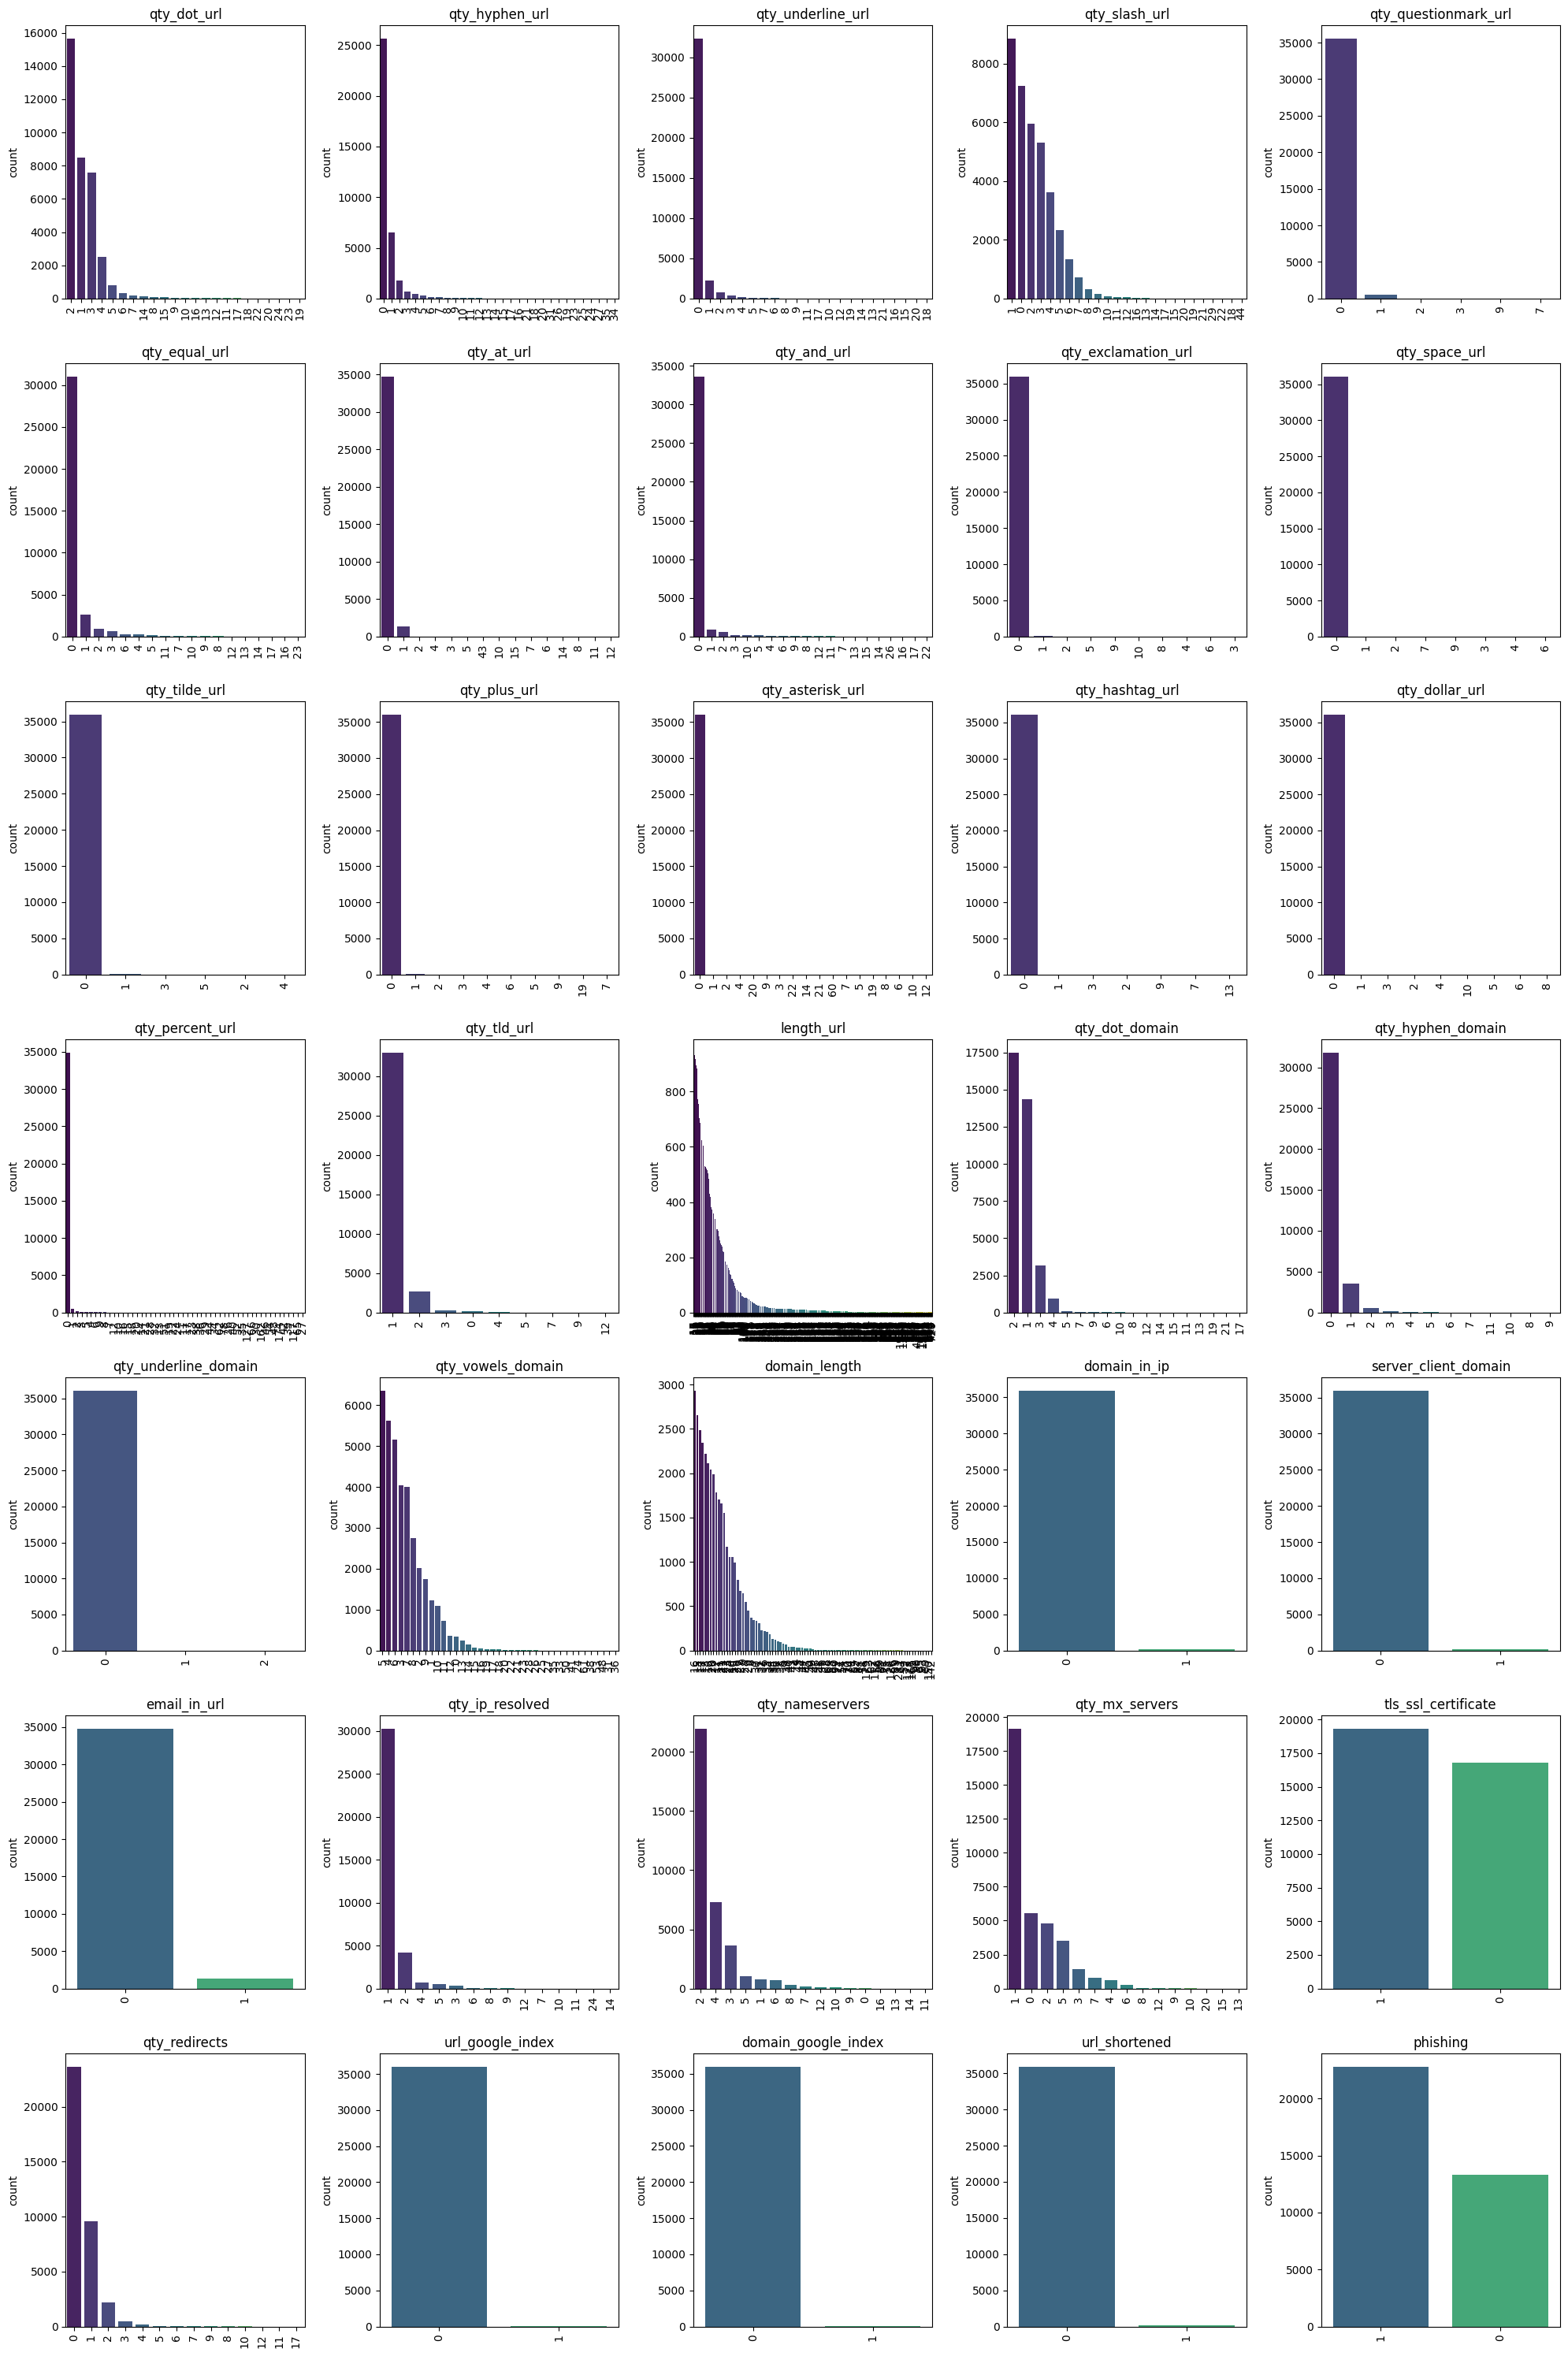

In [34]:
# display features distribution
plot_utils.display_value_counts_with_order(data, data.columns, 5)

---
---
---

## Data Imbalance

In [35]:
# Drop any feature that biased by 80% to a single value.
data = analysis_utils.drop_imbalance_features(data)

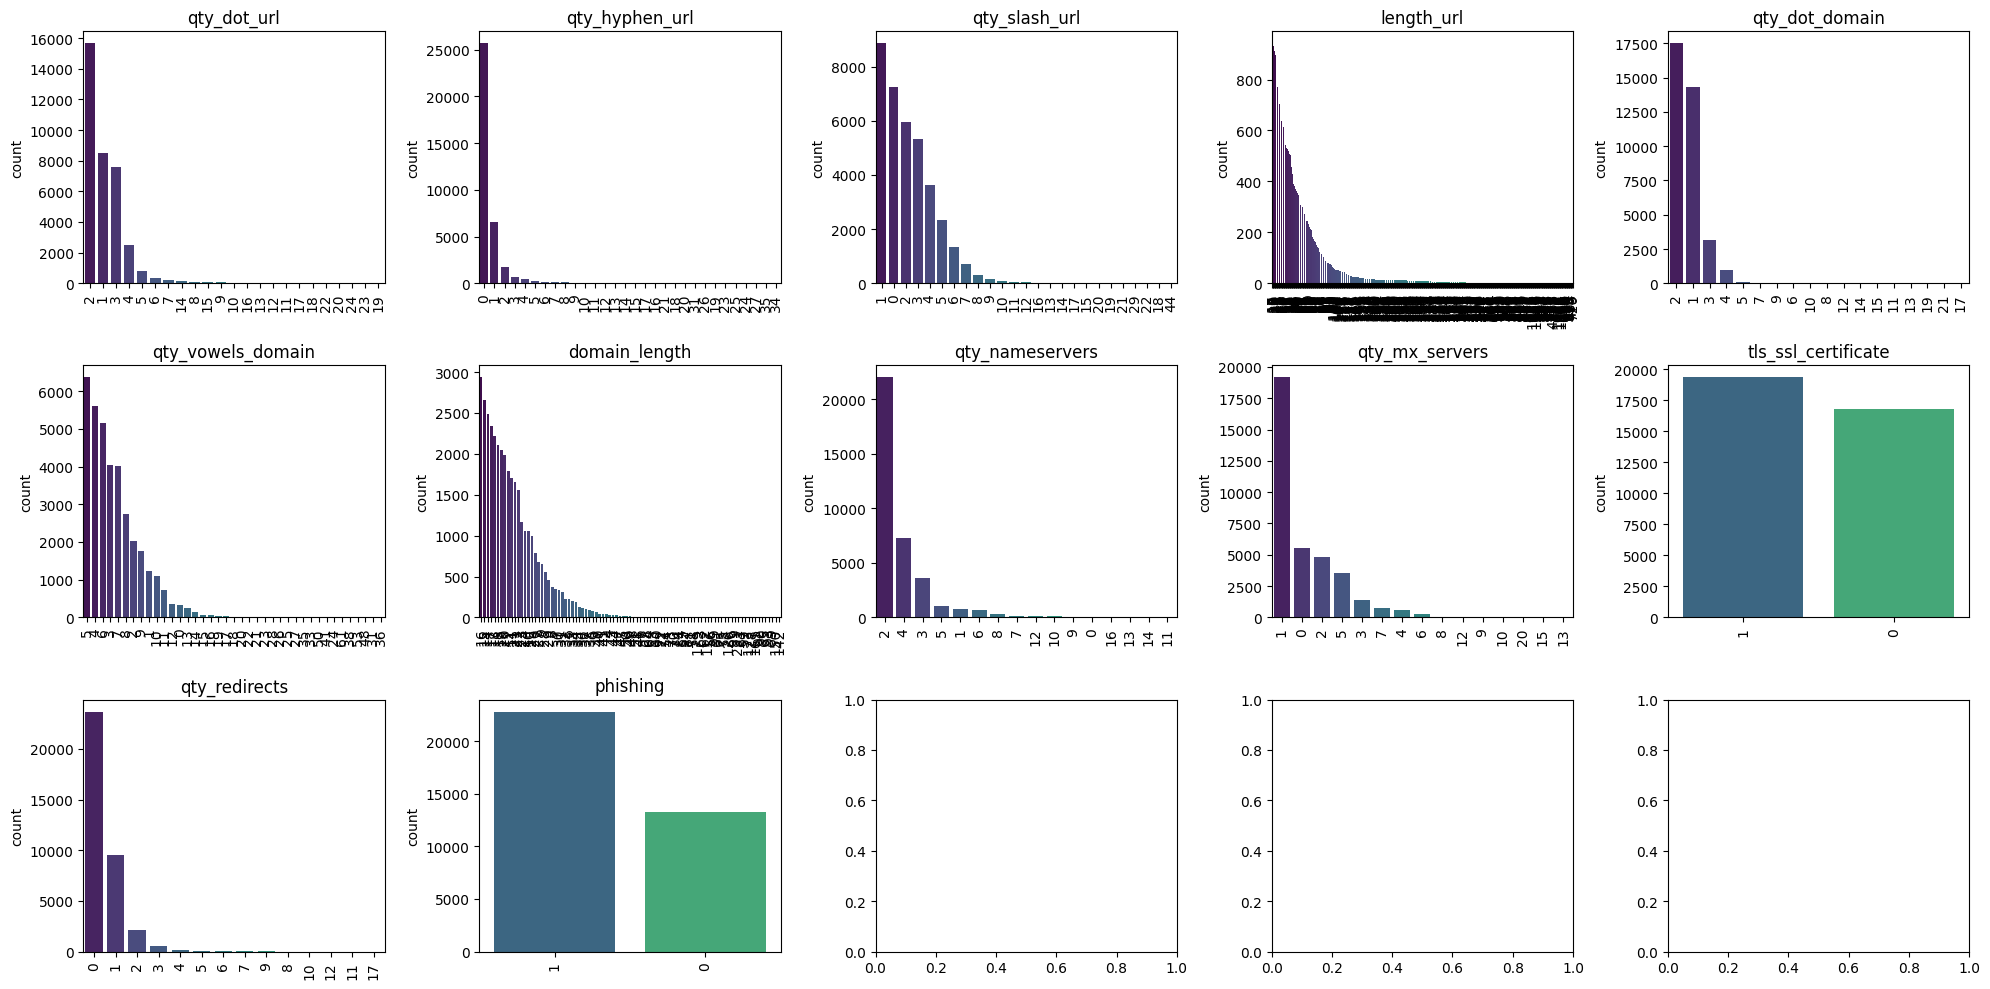

In [36]:
plot_utils.display_value_counts_with_order(data, data.columns, 5, (20, 10))

---
---
---

## Data Correlation

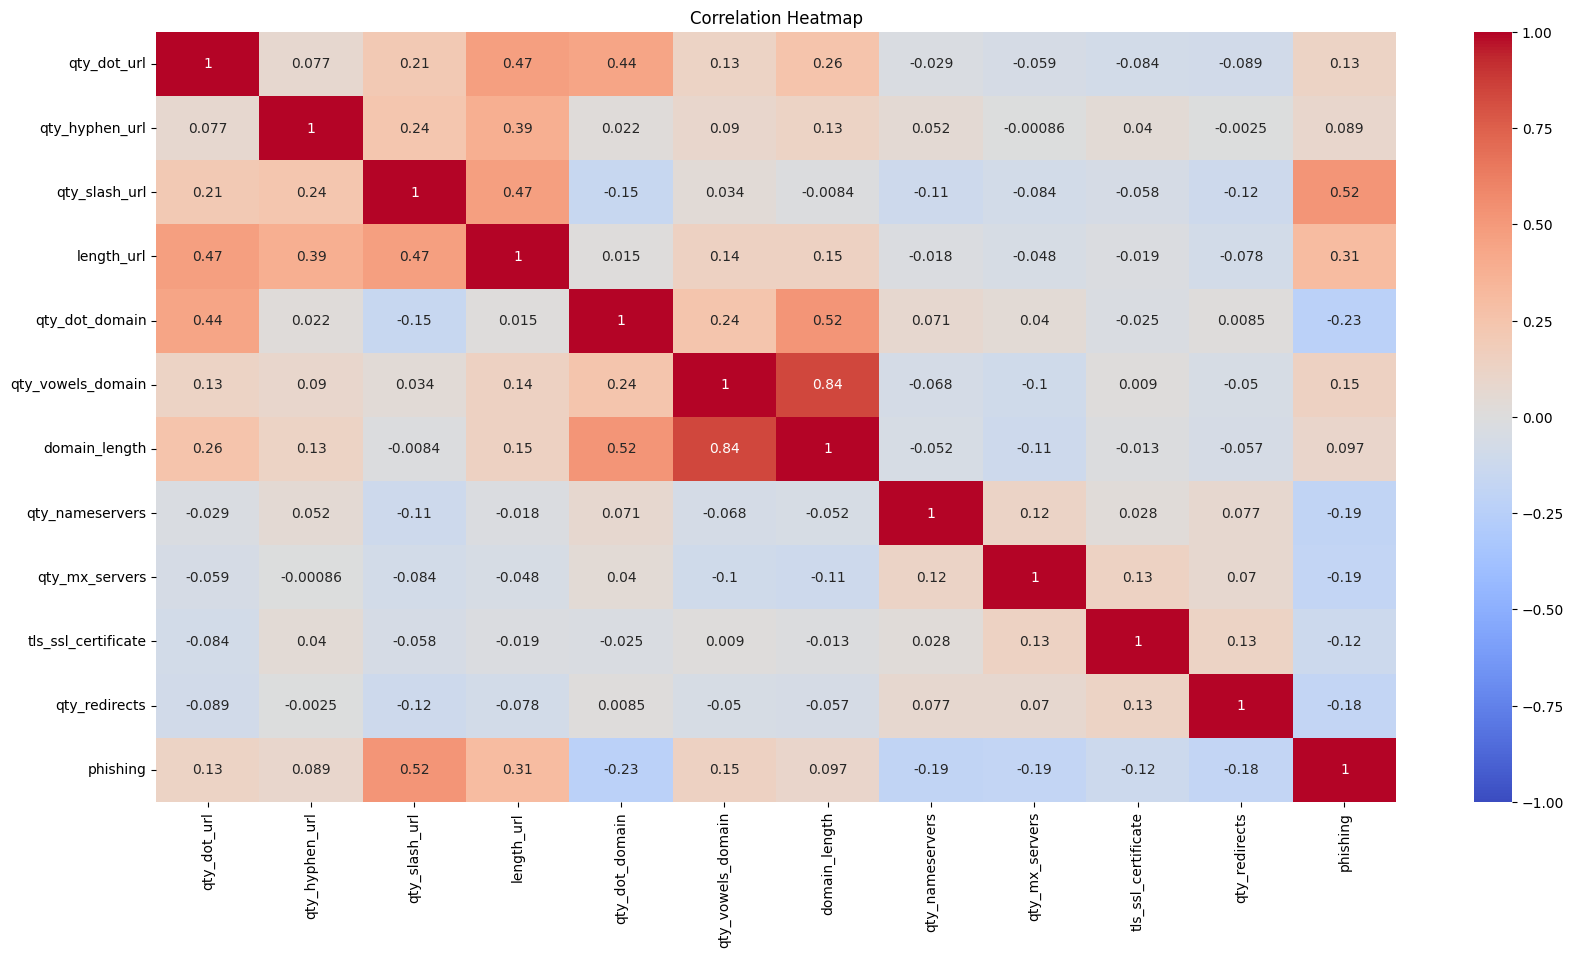

In [37]:
plot_utils.display_correlation(data, 'pearson')

---
---
---

## Feature Selection

In [40]:
# Drop features with high correlation, and keep only features with higher correlation to the target.
data = analysis_utils.drop_highly_correlated_featuers(data)

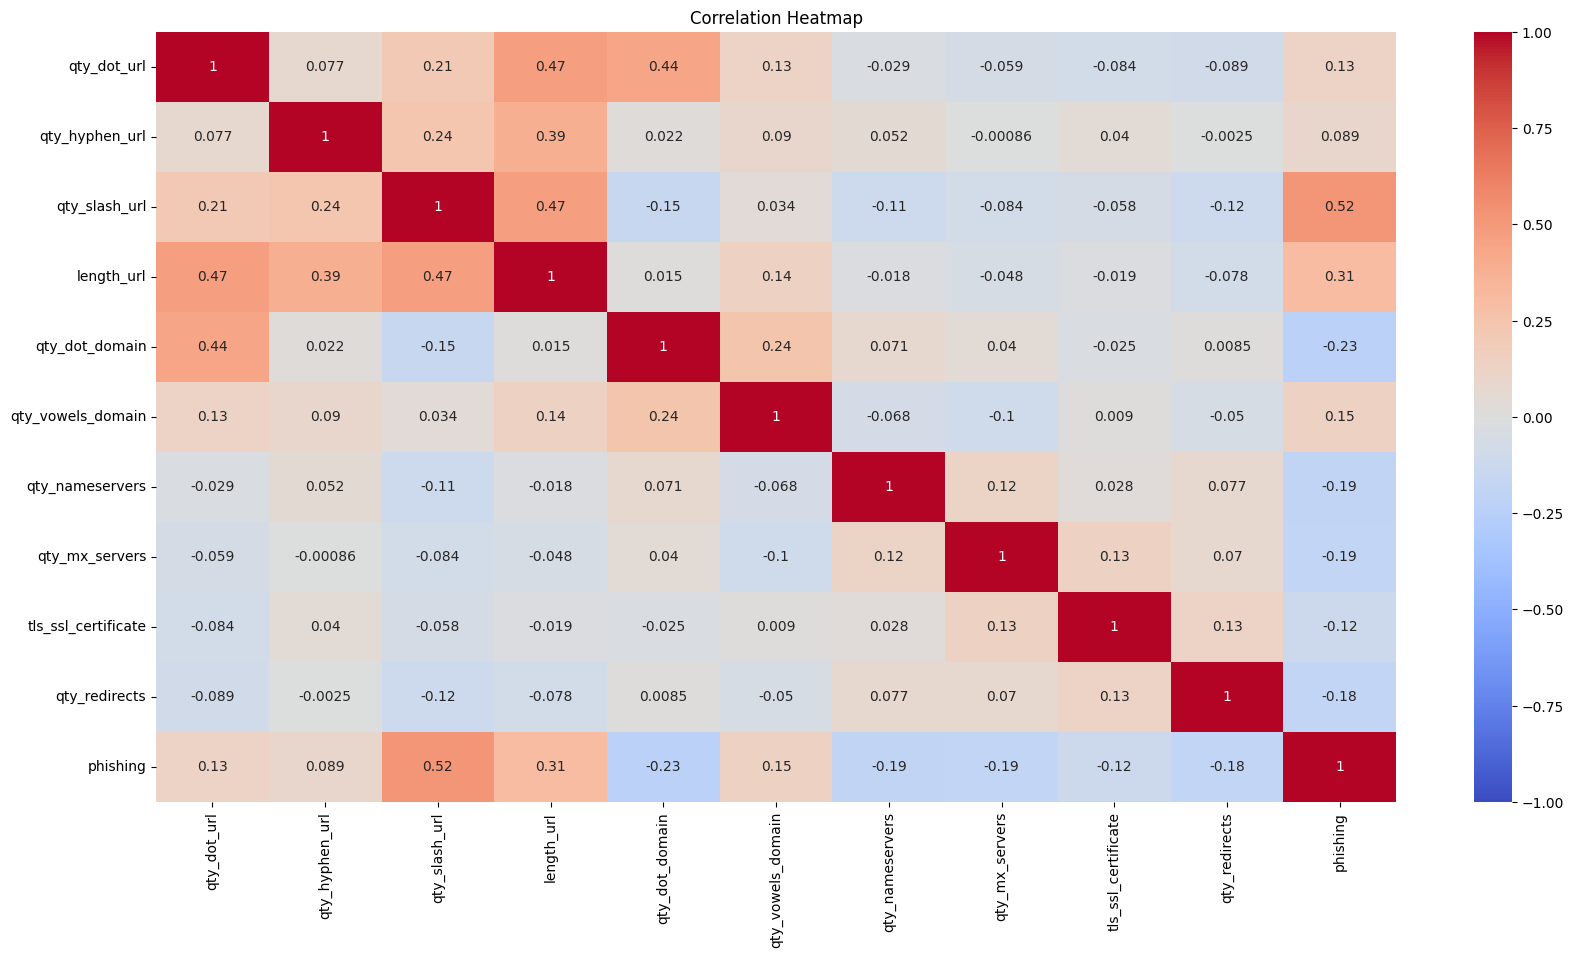

In [41]:
plot_utils.display_correlation(data, 'pearson')

---
---
---

## Split Dataset to Train & Test

In [42]:
# Split data to X and y
X = data.drop(columns=['phishing'])
y = data['phishing']

# List of columns to standardize, excluding categorical column: 'tls_ssl_certificate'
columns_to_standardize = [col for col in X.columns if col != 'tls_ssl_certificate']

# Standardize selected columns
scaler = StandardScaler()
scaled_X = X.copy()  # Make a copy to avoid modifying the original DataFrame
scaled_X[columns_to_standardize] = scaler.fit_transform(X[columns_to_standardize])


# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, stratify=y, random_state=42)

---
---
---

## SVM for Classification

In [46]:
# Define hyper-parameters
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Use grid search for hyper-parameter tuning
svm_classifier = SVC(random_state=42)
svm_grid_search = GridSearchCV(svm_classifier, svm_param_grid, cv=5)
svm_grid_search.fit(X_train, y_train)

# Get the best estimator with the tuned hyper-parameters
best_svm = svm_grid_search.best_estimator_

# Evaluate SVM on the training set
svm_train_predictions = best_svm.predict(X_train)
svm_train_accuracy = accuracy_score(y_train, svm_train_predictions)

# Evaluate SVM on the testing set
svm_test_predictions = best_svm.predict(X_test)
svm_test_accuracy = accuracy_score(y_test, svm_test_predictions)

# Print results
print("Best Parameters for SVM:", svm_grid_search.best_params_)
print("SVM Training Accuracy:", svm_train_accuracy)
print("SVM Testing Accuracy:", svm_test_accuracy)
print("Classification Report (SVM - Testing Set):\n", classification_report(y_test, svm_test_predictions))

Best Parameters for SVM: {'C': 10, 'kernel': 'rbf'}
SVM Training Accuracy: 0.8889734893057382
SVM Testing Accuracy: 0.8797065337763013
Classification Report (SVM - Testing Set):
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      2660
           1       0.90      0.92      0.91      4564

    accuracy                           0.88      7224
   macro avg       0.87      0.87      0.87      7224
weighted avg       0.88      0.88      0.88      7224



---

## Logistic Regression for Classification

In [43]:
# Define hyper-parameters
logistic_param_grid = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2']}

# Use grid search for hyper-parameter tuning
logistic_regression_classifier = LogisticRegression(solver='liblinear', max_iter=5000, random_state=42)
logistic_grid_search = GridSearchCV(logistic_regression_classifier, logistic_param_grid, cv=5)
logistic_grid_search.fit(X_train, y_train)

# Get the best estimator with the tuned hyper-parameters
best_logistic_regression = logistic_grid_search.best_estimator_

# Evaluate Logistic Regression on the training set
logistic_regression_train_predictions = best_logistic_regression.predict(X_train)
logistic_regression_train_accuracy = accuracy_score(y_train, logistic_regression_train_predictions)

# Evaluate Logistic Regression on the testing set
logistic_regression_test_predictions = best_logistic_regression.predict(X_test)
logistic_regression_test_accuracy = accuracy_score(y_test, logistic_regression_test_predictions)

# Print results
print("Best Parameters for Logistic Regression:", logistic_grid_search.best_params_)
print("Logistic Regression Training Accuracy:", logistic_regression_train_accuracy)
print("Logistic Regression Testing Accuracy:", logistic_regression_test_accuracy)
print("Classification Report (Logistic Regression - Testing Set):\n", classification_report(y_test, logistic_regression_test_predictions))

Best Parameters for Logistic Regression: {'C': 10, 'penalty': 'l2'}
Logistic Regression Training Accuracy: 0.8357444452135392
Logistic Regression Testing Accuracy: 0.8301495016611296
Classification Report (Logistic Regression - Testing Set):
               precision    recall  f1-score   support

           0       0.76      0.78      0.77      2660
           1       0.87      0.86      0.86      4564

    accuracy                           0.83      7224
   macro avg       0.82      0.82      0.82      7224
weighted avg       0.83      0.83      0.83      7224



---

## Polynomial Logistic Regression for Classification

In [44]:
# Define hyper-parameters
logistic_param_grid = {'logisticregression__C': [0.1, 1, 10], 'logisticregression__penalty': ['l1', 'l2']}

# Use grid search for hyper-parameter tuning
logistic_regression_classifier = LogisticRegression(solver='liblinear', max_iter=5000, random_state=42)

# Include polynomial features in the pipeline
poly_logistic_pipeline = make_pipeline(PolynomialFeatures(), logistic_regression_classifier)

# Use the pipeline in GridSearchCV
logistic_grid_search = GridSearchCV(poly_logistic_pipeline, logistic_param_grid, cv=5)
logistic_grid_search.fit(X_train, y_train)

# Get the best estimator with the tuned hyper-parameters
best_poly_logistic_regression = logistic_grid_search.best_estimator_

# Evaluate Polynomial Logistic Regression on the training set
poly_logistic_regression_train_predictions = best_poly_logistic_regression.predict(X_train)
poly_logistic_regression_train_accuracy = accuracy_score(y_train, poly_logistic_regression_train_predictions)

# Evaluate Polynomial Logistic Regression on the testing set
poly_logistic_regression_test_predictions = best_poly_logistic_regression.predict(X_test)
poly_logistic_regression_test_accuracy = accuracy_score(y_test, poly_logistic_regression_test_predictions)

# Print results
print("Best Parameters for Polynomial Logistic Regression:", logistic_grid_search.best_params_)
print("Polynomial Logistic Regression Training Accuracy:", poly_logistic_regression_train_accuracy)
print("Polynomial Logistic Regression Testing Accuracy:", poly_logistic_regression_test_accuracy)
print("Classification Report (Polynomial Logistic Regression - Testing Set):\n", classification_report(y_test, poly_logistic_regression_test_predictions))

Best Parameters for Polynomial Logistic Regression: {'logisticregression__C': 1, 'logisticregression__penalty': 'l1'}
Polynomial Logistic Regression Training Accuracy: 0.8538796982072403
Polynomial Logistic Regression Testing Accuracy: 0.8529900332225914
Classification Report (Polynomial Logistic Regression - Testing Set):
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      2660
           1       0.89      0.88      0.88      4564

    accuracy                           0.85      7224
   macro avg       0.84      0.84      0.84      7224
weighted avg       0.85      0.85      0.85      7224



---

## XGBoost for Classification

In [45]:
# Define hyper-parameters
xgboost_param_grid = {'n_estimators': [25, 50, 100, 200]}

# Use grid search for hyper-parameter tuning
xgboost_classifier = XGBClassifier(random_state=42)
xgboost_grid_search = GridSearchCV(xgboost_classifier, xgboost_param_grid, cv=5)
xgboost_grid_search.fit(X_train, y_train)

# Get the best estimator with the tuned hyper-parameters
best_xgboost = xgboost_grid_search.best_estimator_

# Evaluate XGBoost on the training set
xgboost_train_predictions = best_xgboost.predict(X_train)
xgboost_train_accuracy = accuracy_score(y_train, xgboost_train_predictions)

# Evaluate XGBoost on the testing set
xgboost_test_predictions = best_xgboost.predict(X_test)
xgboost_test_accuracy = accuracy_score(y_test, xgboost_test_predictions)

# Print results
print("\nBest Parameters for XGBoost:", xgboost_grid_search.best_params_)
print("XGBoost Training Accuracy:", xgboost_train_accuracy)
print("XGBoost Testing Accuracy:", xgboost_test_accuracy)
print("Classification Report (XGBoost - Testing Set):\n", classification_report(y_test, xgboost_test_predictions))



Best Parameters for XGBoost: {'n_estimators': 200}
XGBoost Training Accuracy: 0.9221983802865646
XGBoost Testing Accuracy: 0.8934108527131783
Classification Report (XGBoost - Testing Set):
               precision    recall  f1-score   support

           0       0.86      0.85      0.85      2660
           1       0.91      0.92      0.92      4564

    accuracy                           0.89      7224
   macro avg       0.89      0.88      0.89      7224
weighted avg       0.89      0.89      0.89      7224

